# System Identification of a PM Electric Motor

The aim of this project is to identify the system model of a permanent magnet electric motor by using neural networks.

# 1. Import Required Libraries, Set Hyperparameters and Define Reference Position

In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np, numpy.random
from tqdm.auto import tqdm
from timeit import default_timer as timer
from datetime import datetime
import pandas as pd
# %matplotlib widget
import helper_functions as hp
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

IN_FEATURES = 1
OUT_FEATURES = 1
HIDDEN_UNITS = 8
LEARNING_RATE = 0.001
DT = 0.001
EPOCHS = 21
TRAIN_TEST_RATIO = 0.8

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")

hp.set_seeds()

Using device: cpu
Manual seed is set as 42.


# 2. Import Model Response and Split Data for Training

(8000, 8000, 2001, 2001)

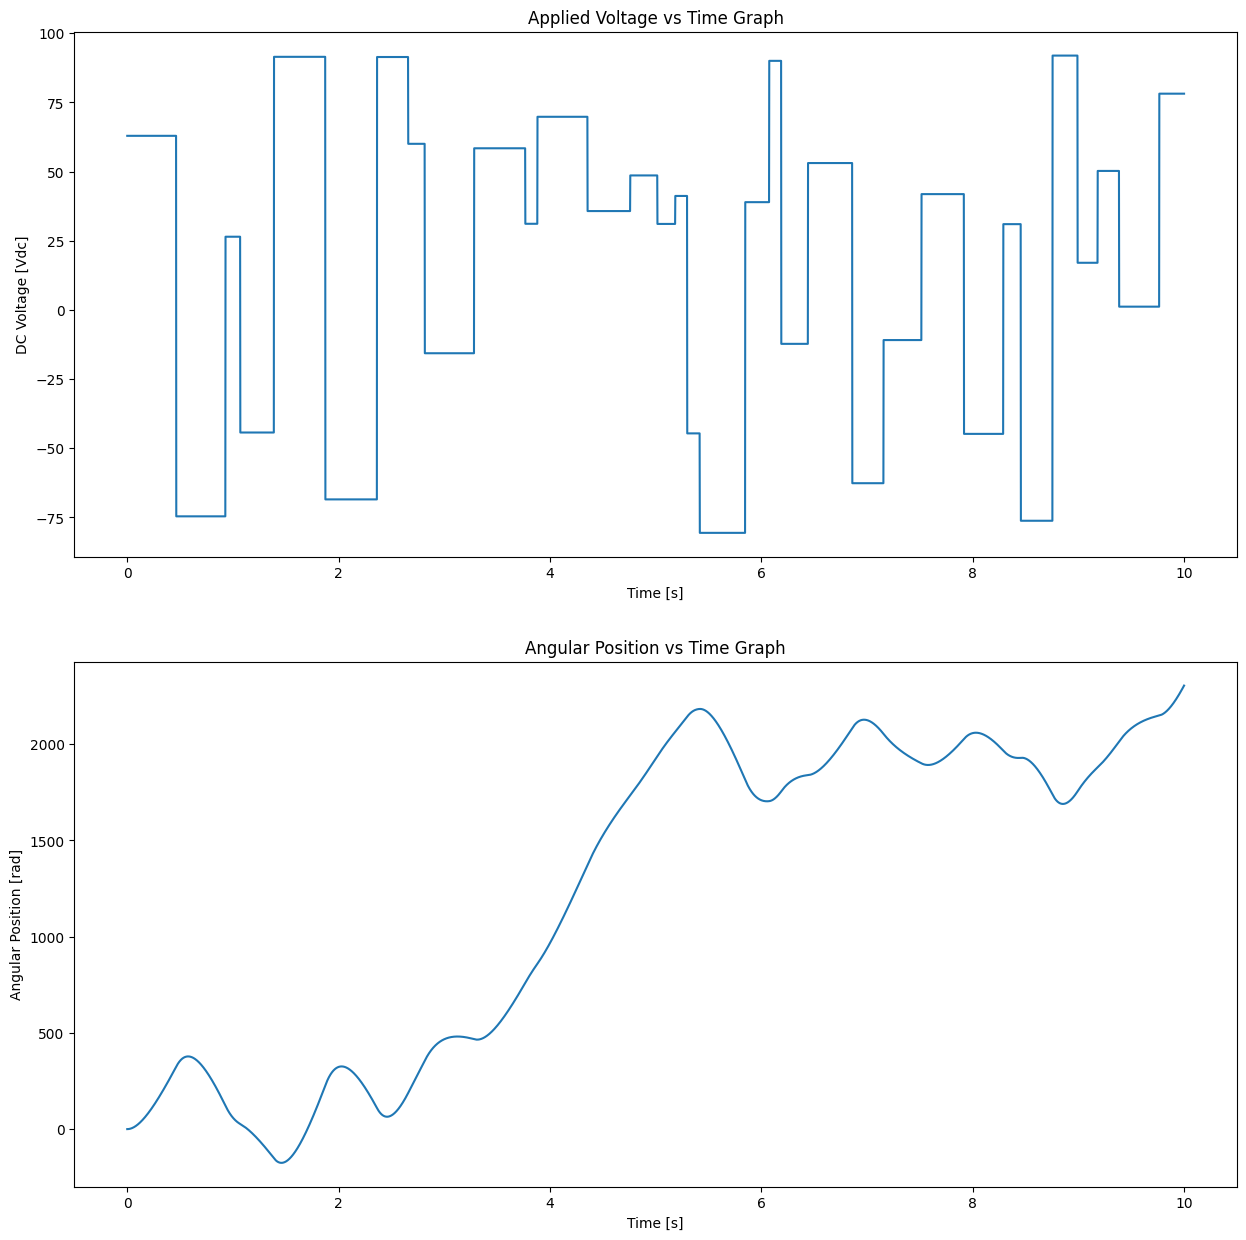

In [17]:
FILE_NAME = "data_001.csv"
df = pd.read_csv(FILE_NAME)

Vdc = torch.Tensor(df["U"].values,device=device)
theta = torch.Tensor(df["Y"].values,device=device)
size = len(Vdc)
# time = torch.arange(start=0,end=int((len(Vdc)-1)*DT),step=DT,device=device)
time = torch.arange(start=0,end=size*DT,step=DT,device=device)


plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(time,Vdc,label="Input Signal (Vdc [Vdc])")
plt.xlabel("Time [s]")
plt.ylabel("DC Voltage [Vdc]")
plt.title("Applied Voltage vs Time Graph")
plt.subplot(2,1,2)
plt.plot(time,theta,label="Output Signal (Theta [rad])")
plt.xlabel("Time [s]")
plt.ylabel("Angular Position [rad]")
plt.title("Angular Position vs Time Graph")

# Create train/test split
ref_size = int(TRAIN_TEST_RATIO * len(Vdc))
Vdc_train, theta_train = Vdc[:ref_size], theta[:ref_size]
Vdc_test, theta_test = Vdc[ref_size:], theta[ref_size:]

len(Vdc_train), len(theta_train), len(Vdc_test), len(theta_test)

# 3. Neural Network Controller Model Setup

In [15]:
# Subclass nn.Module to make our model
class NNControllerModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_features=input_features, out_features=hidden_units),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidden_units, out_features=output_features),
                                #    nn.Tanh()
                                  )
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.layer(x)
        if output > 100:
            output = 100
        elif output < -100:
            output = -100
        return output

model_1 = NNControllerModel(input_features=1, 
                            output_features=1, 
                            hidden_units=32).to(device)

# 4. Loss Function and Optimizer Setup

In [16]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)

# 5. Perform the Training

In [ ]:
train_time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    
    epoch_calc_start = timer()

    model_1.train()
    Vdc_ref = torch.zeros(size=[ref_size,OUT_FEATURES],device=device)
    Ia_ref = torch.zeros(size=[ref_size,1],device=device)
    theta_ref = torch.zeros(size=[ref_size,1],device=device)
    theta_dot_ref = torch.zeros(size=[ref_size,1],device=device)
    error_ref = torch.zeros(size=[ref_size,IN_FEATURES],device=device)

    for i in range(ref_size-1):
        error_ref = reference_position - theta_ref
        Vdc_ref[i] = model_1(error_ref[i])
        theta_ref[i+1], theta_dot_ref[i+1], Ia_ref[i+1] = motor(theta_current=theta_ref[i],
                                                                theta_dot_current=theta_dot_ref[i],
                                                                Ia_current=Ia_ref[i],
                                                                Vdc_current=Vdc_ref[i],
                                                                dt=DT)

    loss = loss_fn(theta_ref, reference_position)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_calc_time = timer()- epoch_calc_start
    
    # Evaluate Model
    model_1.eval()
    with torch.inference_mode():
        Vdc_test = torch.zeros(size=[test_size,OUT_FEATURES],device=device)
        Ia_test = torch.zeros(size=[test_size,1],device=device)
        theta_test = torch.zeros(size=[test_size,1],device=device)
        theta_dot_test = torch.zeros(size=[test_size,1],device=device)
        error_test = torch.zeros(size=[test_size,IN_FEATURES],device=device)

        for i in range(test_size-1):
            error_test = test_position - theta_test
            Vdc_test[i] = model_1(error_test[i])
            theta_test[i+1], theta_dot_test[i+1], Ia_test[i+1] = motor(theta_current=theta_test[i],
                                                                        theta_dot_current=theta_dot_test[i],
                                                                        Ia_current=Ia_test[i],
                                                                        Vdc_current=Vdc_test[i],
                                                                        dt=DT)

        loss_eval = loss_fn(theta_test, test_position)
        writer.add_scalars("Loss", {"Train Loss":loss,
                                    "Test Loss":loss_eval}, epoch)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {loss_eval:.3f}")
        print(f"Single Epoch Training Time: {epoch_calc_time:.3f} s\n")

print(f"Total Training Time: {timer()-train_time_start:.3f} s")
writer.close()